In [1]:
import numpy as np
import os
from os import listdir
import matplotlib.pyplot as plt

In [9]:
from zipfile import ZipFile as zipFileMod

file_name = "datasetFaceEmotions.zip"

# opening the zip file in READ mode
with zipFileMod(file_name, 'r') as zip_folder:
    # printing all the contents of the zip file
    zip_folder.printdir()

    # extracting all the files
    print('Extracting all the files now...')
    zip_folder.extractall()
    print('Done!')

File Name                                             Modified             Size
images/train/angry/0.jpg                       2019-10-17 04:41:48         1521
images/train/angry/1.jpg                       2019-10-17 04:41:48         1690
images/train/angry/10.jpg                      2019-10-17 04:41:48         1693
images/train/angry/10002.jpg                   2019-10-17 04:41:48         1649
images/train/angry/10016.jpg                   2019-10-17 04:41:48         1726
images/train/angry/10037.jpg                   2019-10-17 04:41:48         1453
images/train/angry/10038.jpg                   2019-10-17 04:41:48         1753
images/train/angry/10057.jpg                   2019-10-17 04:41:48         1793
images/train/angry/10063.jpg                   2019-10-17 04:41:48         1666
images/train/angry/10069.jpg                   2019-10-17 04:41:48         1737
images/train/angry/10100.jpg                   2019-10-17 04:41:48         1478
images/train/angry/10105.jpg            

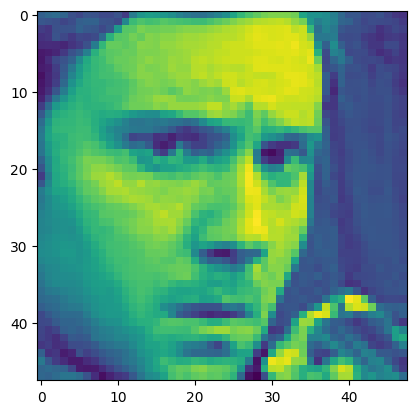

In [2]:
img_test = plt.imread("images/train/angry/0.jpg")
plt.imshow(img_test)

In [3]:
def labelNumber(label):
    match label:
        case "angry":
            return 0
        case "happy":
            return 1
        case "disgust":
            return 2
        case "surprise":
            return 3
        case "neutral":
            return 4
        case "sad":
            return 5
        case "fear":
            return 6

In [4]:
#Import the train dataset

nb_labels = len(listdir("images/train"))
print("number of labels :", nb_labels)
X_train = []
Labels_train = []
NamesCollections_train = []

for k,label in enumerate(listdir("images/train")):
  #print(label)
  # print(k)
  #print(len(listdir("images/train/" + label)))
  for image in listdir("images/train/" + label):
    X_train.append(plt.imread("images/train/" + label + "/" + image))
    #print("images/train/" + label + "/" + image)
    labelNum = labelNumber(label)
    Labels_train.append(labelNum)
    NamesCollections_train.append("images/train/" + label + "/" + image)

X_train = np.array(X_train)
Labels_train = np.array(Labels_train)
print(X_train.shape)
print(Labels_train.shape)

number of labels : 7
(28821, 48, 48)
(28821,)


In [5]:
#Import the test dataset

X_test = []
Labels_test = []
NamesCollections_test = []

for k,label in enumerate(listdir("images/validation")):
  #print(label)
  # print(k)
  for image in listdir("images/validation/" + label):
    X_test.append(plt.imread("images/validation/" + label + "/" + image))
    labelNum = labelNumber(label)
    Labels_test.append(labelNum)
    NamesCollections_test.append("images/validation/" + label + "/" + image)

X_test = np.array(X_test)
Labels_test = np.array(Labels_test)
print(X_test.shape)
print(Labels_test.shape)


(7066, 48, 48)
(7066,)


1
images/train/happy/26261.jpg


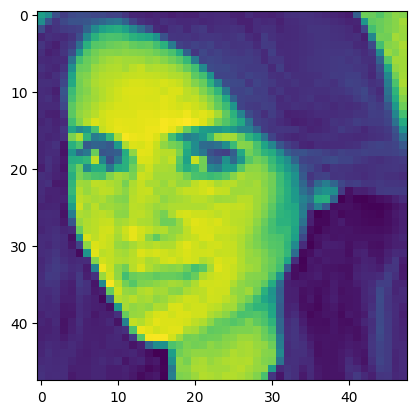

In [6]:
n = 12172
plt.imshow(X_train[n])
print(Labels_train[n])
print(NamesCollections_train[n])

In [7]:
#functions of non-linear activations
def f_sigmoid(X, deriv=False):
    if not deriv:
        return 1 / (1 + np.exp(-X))
    else:
        return f_sigmoid(X)*(1 - f_sigmoid(X))

def f_softmax(X):
    Z = np.sum(np.exp(X), axis=1)
    Z = Z.reshape(Z.shape[0], 1)
    return np.exp(X) / Z

def f_relu(X, deriv=False):
    if not deriv:
        return np.maximum(0,X)
    else:
        return ((X>0)*1)+0

In [8]:
#Functionality of a single hidden layer
class Layer:
    def __init__(self, size, batch_size, is_input=False, is_output=False,
                 activation=f_sigmoid):
        self.is_input = is_input
        self.is_output = is_output

        # Z is the matrix that holds output values
        self.Z = np.zeros((batch_size, size[0]))
        # The activation function is an externally defined function (with a
        # derivative) that is stored here
        self.activation = activation

        # W is the outgoing weight matrix for this layer
        self.W = None
        # S is the matrix that holds the inputs to this layer
        self.S = None
        # D is the matrix that holds the deltas for this layer
        self.D = None
        # Fp is the matrix that holds the derivatives of the activation function
        self.Fp = None

        if not is_input:
            self.S = np.zeros((batch_size, size[0]))
            self.D = np.zeros((batch_size, size[0]))

        if not is_output:
            self.W = np.random.normal(size=size, scale=1E-4)

        if not is_input and not is_output:
            self.Fp = np.zeros((size[0], batch_size))

    def forward_propagate(self):
        if self.is_input:
            return self.Z.dot(self.W)

        self.Z = self.activation(self.S)
        if self.is_output:
            return self.Z
        else:
            # For hidden layers, we add the bias values here
            self.Z = np.append(self.Z, np.ones((self.Z.shape[0], 1)), axis=1)
            self.Fp = self.activation(self.S, deriv=True).T
            return self.Z.dot(self.W)

In [ ]:
#Convolutional & pooling layer
class ConvLayer:
    def __init__(self, input_shape, num_filters, filter_size, activation=f_relu):
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.activation = activation

        # Initialize the filters with random weights
        self.filters = np.random.normal(size=(num_filters, filter_size[0], filter_size[1]), scale=1E-4)

        # Initialize the biases with zeros
        self.biases = np.zeros(num_filters)

        # Initialize the output of the convolution with zeros
        self.output = np.zeros((input_shape[0], input_shape[1]-filter_size[0]+1, input_shape[2]-filter_size[1]+1, num_filters))

    def convolve(self, input_data):
        # Iterate over the filters and apply the convolution operation
        for f in range(self.num_filters):
            for i in range(self.input_shape[0]):
                for j in range(self.input_shape[1]-self.filter_size[0]+1):
                    for k in range(self.input_shape[2]-self.filter_size[1]+1):
                        self.output[i,j,k,f] = np.sum(input_data[i,j:j+self.filter_size[0],k:k+self.filter_size[1]] * self.filters[f]) + self.biases[f]

        # Apply the activation function to the output
        self.output = self.activation(self.output)

        return self.output


class PoolingLayer:
    def __init__(self, input_shape, pool_size):
        self.input_shape = input_shape
        self.pool_size = pool_size

        # Initialize the output of the pooling operation with zeros
        self.output = np.zeros((input_shape[0], input_shape[1]//pool_size[0], input_shape[2]//pool_size[1], input_shape[3]))

    def pool(self, input_data):
        # Iterate over the input data and apply the pooling operation
        for i in range(self.input_shape[0]):
            for j in range(self.input_shape[1]//self.pool_size[0]):
                for k in range(self.input_shape[2]//self.pool_size[1]):
                    for f in range(self.input_shape[3]):
                        self.output[i,j,k,f] = np.max(input_data[i,j*self.pool_size[0]:j*self.pool_size[0]+self.pool_size[0],k*self.pool_size[1]:k*self.pool_size[1]+self.pool_size[1],f])
        return self.output



In [23]:
class MultiLayerPerceptron:
    def __init__(self, layer_config, batch_size=100):
        self.layers = []
        self.num_layers = len(layer_config)
        self.minibatch_size = batch_size

        for i in range(self.num_layers-1):
            if i == 0:
                print ("Initializing input layer with size {0}.".format(layer_config[i]))
                # Here, we add an additional unit at the input for the bias
                # weight.
                self.layers.append(Layer([layer_config[i]+1, layer_config[i+1]],
                                         batch_size,
                                         is_input=True))
            else:
                print ("Initializing hidden layer with size {0}.".format(layer_config[i]))
                # Here we add an additional unit in the hidden layers for the
                # bias weight.
                self.layers.append(Layer([layer_config[i]+1, layer_config[i+1]],
                                         batch_size,
                                         activation=f_sigmoid))

        print ("Initializing output layer with size {0}.".format(layer_config[-1]))
        self.layers.append(Layer([layer_config[-1], None],
                                 batch_size,
                                 is_output=True,
                                 activation=f_softmax))
        print ("Done!")

    def forward_propagate(self, data):
        # We need to be sure to add bias values to the input
        self.layers[0].Z = np.append(data, np.ones((data.shape[0], 1)), axis=1)

        for i in range(self.num_layers-1):
            self.layers[i+1].S = self.layers[i].forward_propagate()
        return self.layers[-1].forward_propagate()

    def backpropagate(self, yhat, labels):
        
        #exit_with_err("FIND ME IN THE CODE, What is computed in the next line of code?\n")
        
        self.layers[-1].D = (yhat - labels).T
        for i in range(self.num_layers-2, 0, -1):
            # We do not calculate deltas for the bias values
            W_nobias = self.layers[i].W[0:-1, :]
            
            #exit_with_err("FIND ME IN THE CODE, What does this 'for' loop do?\n")
            
            self.layers[i].D = W_nobias.dot(self.layers[i+1].D) * self.layers[i].Fp

    def update_weights(self, eta):
        for i in range(0, self.num_layers-1):
            # print("W antes \n")
            # print(self.layers[i].W[0][0])
            # print("D \n")
            # print(self.layers[i+1].D[0][0])
            # print("Z \n")
            # print(self.layers[i].Z[0][0])
            W_grad = -eta*(self.layers[i+1].D.dot(self.layers[i].Z)).T
            self.layers[i].W += W_grad
            # print("W despues \n")
            # norm = np.linalg.norm(self.layers[i].W)
            # if(norm != 0):
            #     print(np.linalg.norm(W_grad) / norm)
            # print(self.layers[i].W[0][0])


    def evaluate(self, train_data, train_labels, test_data, test_labels,
                 num_epochs=70, eta=0.05, eval_train=False, eval_test=True):

        N_train = len(train_labels)*len(train_labels[0])
        N_test = len(test_labels)*len(test_labels[0])

        print ("Training for {0} epochs...".format(num_epochs))
        for t in range(0, num_epochs):
            out_str = "[{0:4d}] ".format(t)

            for b_data, b_labels in zip(train_data, train_labels):
                output = self.forward_propagate(b_data)
                self.backpropagate(output, b_labels)
                
                #exit_with_err("FIND ME IN THE CODE, How does weight update is implemented? What is eta?\n")

                self.update_weights(eta=eta)

            if eval_train:
                errs = 0
                for b_data, b_labels in zip(train_data, train_labels):
                    output = self.forward_propagate(b_data)
                    yhat = np.argmax(output, axis=1)
                    errs += np.sum(1-b_labels[np.arange(len(b_labels)), yhat])

                out_str = ("{0} Training error: {1:.5f}".format(out_str,
                                                           float(errs)/N_train))

            if eval_test:
                errs = 0
                for b_data, b_labels in zip(test_data, test_labels):
                    output = self.forward_propagate(b_data)
                    yhat = np.argmax(output, axis=1)
                    errs += np.sum(1-b_labels[np.arange(len(b_labels)), yhat])

                out_str = ("{0} Test error: {1:.5f}").format(out_str,
                                                       float(errs)/N_test)

            print (out_str)

In [11]:
def label_to_bit_vector(labels, nbits):
    bit_vector = np.zeros((labels.shape[0], nbits))
    for i in range(labels.shape[0]):
        bit_vector[i, labels[i]] = 1.0

    return bit_vector

In [12]:
def create_batches(data, labels, batch_size, create_bit_vector=False):
    N = data.shape[0]
    print ("Batch size {0}, the number of examples {1}.".format(batch_size,N))

    if N % batch_size != 0:
        print ("Warning in create_minibatches(): Batch size {0} does not " \
              "evenly divide the number of examples {1}.".format(batch_size,N))
    chunked_data = []
    chunked_labels = []
    idx = 0
    while idx + batch_size <= N:
        chunked_data.append(data[idx:idx+batch_size, :])
        if not create_bit_vector:
            chunked_labels.append(labels[idx:idx+batch_size])
        else:
            bit_vector = label_to_bit_vector(labels[idx:idx+batch_size], 7)
            chunked_labels.append(bit_vector)

        idx += batch_size

    return chunked_data, chunked_labels

In [13]:
def prepare_for_backprop(batch_size, Train_images, Train_labels, Valid_images, Valid_labels):
    
    print ("Creating data...")
    batched_train_data, batched_train_labels = create_batches(Train_images, Train_labels,
                                              batch_size,
                                              create_bit_vector=True)
    batched_valid_data, batched_valid_labels = create_batches(Valid_images, Valid_labels,
                                              batch_size,
                                              create_bit_vector=True)
    print ("Done!")


    return batched_train_data, batched_train_labels,  batched_valid_data, batched_valid_labels

In [14]:
Xtrain = X_train.reshape(X_train .shape[0], X_train .shape[1] * X_train .shape[2])
Xtest = X_test.reshape(X_test .shape[0], X_test .shape[1] * X_test .shape[2])

Xtrain = Xtrain.astype('float32')
Xtest = Xtest.astype('float32')
Xtrain /= 255
Xtest /= 255

In [24]:
batch_size=500

train_data, train_labels, valid_data, valid_labels=prepare_for_backprop(batch_size, Xtrain[0:28000,:], Labels_train[:28000], Xtest[0:7000,:], Labels_test[:7000])


mlp = MultiLayerPerceptron(layer_config=[2304, 1000, 500, 100, 50, 7], batch_size=batch_size)

mlp.evaluate(train_data, train_labels, valid_data, valid_labels, num_epochs=10,
             eval_train=True, eta=0.05)

print("Done:)\n")

Creating data...
Batch size 500, the number of examples 28000.
Batch size 500, the number of examples 7000.
Done!
Initializing input layer with size 2304.
Initializing hidden layer with size 1000.
Initializing hidden layer with size 500.
Initializing hidden layer with size 100.
Initializing hidden layer with size 50.
Initializing output layer with size 7.
Done!
Training for 10 epochs...
[   0]  Training error: 0.91486 Test error: 0.89557
[   1]  Training error: 0.91486 Test error: 0.89557
[   2]  Training error: 0.91486 Test error: 0.89557
[   3]  Training error: 0.91486 Test error: 0.89557
[   4]  Training error: 0.91486 Test error: 0.89557
[   5]  Training error: 0.91486 Test error: 0.89557
[   6]  Training error: 0.91486 Test error: 0.89557
[   7]  Training error: 0.91486 Test error: 0.89557
[   8]  Training error: 0.91486 Test error: 0.89557
[   9]  Training error: 0.91486 Test error: 0.89557
Done:)

